<div class="alert alert-block alert-success">
This jupyter notebook is part of the supplementary material for the book "Materials Data Science" (Stefan Sandfeld, Springer, 2024, DOI 10.1007/978-3-031-46565-9). For further details please refer to the accompanying webpage at <a href="https://mds-book.org">https://mds-book.org</a>.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange   # just for showing a progress bar



# Import a set of activation functions and their derivatives (specific function hardcoded in the activation layer). 
# Note that the tanh function works significantly better than the sigmoid.
from utilities import sigmoidal_function, sigmoidal_derivative
from utilities import tanh_function, tanh_derivative
from utilities import relu_function, relu_derivative
from utilities import leakyrelu_function, leakyrelu_derivative

# Use the same abstract base class as in the previous chapter for the FCN implementation:
from utilities import NNLayer

## 19.5 Generative Adversarial Networks – or: How to Create Data?
### 19.5.6 Python Implementation

In [2]:

class Gan:
    def __init__(self, cost_function, derivative_of_cost):
        self.layers_gen = []
        self.layers_disc = []
        self.cost_function = cost_function
        self.derivative_of_cost = derivative_of_cost

    def add_layer(self, layer, model):
        if model == 'gen':
            self.layers_gen.append(layer)
        elif model == 'disc':
            self.layers_disc.append(layer)

    def train(self, X_train, z_dim, epochs, learning_rate, decay, batch):
        all_costs = []
        progress_bar = trange(epochs)
        for epoch in progress_bar:
            np.random.shuffle(X_train)
            X_train_batch = np.array_split(X_train, int(len(X_train) / batch))

            for x_train in X_train_batch:
                # 1 - sample the noise vector from a normal distribution
                noise = np.random.normal(0, 1, (x_train.shape[0], z_dim))

                # 2 - generate 'fake' example by giving noise as input
                #     to the forward propagation of the generator
                fake = noise
                for layer in self.layers_gen:
                    fake = layer.feed_forward(fake)

                # 3 - obtain prediction for the fake image
                fake_pred = fake
                for layer in self.layers_disc:
                    fake_pred = layer.feed_forward(fake_pred, store_to_memory=True)

                # 4 - obtain prediction for the real image
                real_pred = x_train
                for layer in self.layers_disc:
                    real_pred = layer.feed_forward(real_pred)

                # 5 - we compare the predictions for the real and fake with the reference
                # real example --> output of discriminator is 1
                # fake example --> output is 0

                real_cost = self.cost_function(1., real_pred)
                fake_cost = self.cost_function(0., fake_pred)

                # the cost function for the discriminator is the mean of the prediction
                cost_D = 0.5 * np.mean(fake_cost + real_cost)

                # 6 - backpropagate errors from both predictions
                real_error = self.derivative_of_cost(1., real_pred)
                for layer in reversed(self.layers_disc):
                    real_error = layer.backward_propagation(
                        real_error, learning_rate, store_update=True, update_weights=False
                    )

                fake_error = self.derivative_of_cost(0., fake_pred)
                for layer in reversed(self.layers_disc):
                    fake_error = layer.backward_propagation(
                        fake_error, learning_rate, use_memory=True
                    )

                # 7 - update the generator based on the feedback from the discriminator
                # to do so, we want the generator to 'fool' the discriminator
                # the discr. should thus output 1 for the fake example instead of 0
                cost_G = np.mean(self.cost_function(1., fake_pred))

                # 8 - backpropagate errors for the generator
                gen_error = self.derivative_of_cost(1., fake_pred)
                for layer in reversed(self.layers_disc):
                    gen_error = layer.backward_propagation(
                        gen_error, learning_rate, update_weights=False, use_memory=True
                    )

                for layer in reversed(self.layers_gen):
                    gen_error = layer.backward_propagation(
                        gen_error, learning_rate
                    )

            progress_bar.set_postfix({'Loss Gen': cost_G,
                                      'Loss Disc real': np.mean(real_cost),
                                      'Loss Disc fake': np.mean(fake_cost)})
            all_costs.append([cost_D, cost_G])
            learning_rate *= (1 / (1 + decay * epoch))

        return np.array(all_costs)
    
    def generate(self, batch, z_dim):
        noise = np.random.normal(0, 1, (batch, z_dim))
        fake = noise
        for layer in self.layers_gen:
            fake = layer.feed_forward(fake)

        return fake


### Additional, required classes (not printed in the book for brevity)
Define the cost function and its derivative 

In [3]:
def BCE(y_true, y_pred):
    # y_pred = np.clip(y_pred, eps, 1-eps)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def dBCE_dy(y_true, y_pred):
    eps = 1e-8
    return - y_true / (y_pred+eps) + (1 - y_true) / (1 - y_pred + eps)

### Do the concrete implementation of a FCL and a AL
The FCL needs to be adapted (as compared to the FCN Layer from the previous chapter) because, e.g., in the feed forward step we now need to decide wether or no to store the value of `x` for later use.

In [4]:
class FullyConnectedLayer(NNLayer):

    def __init__(self, n_inputs, n_outputs, seed=42):
        """Initialize the state of the FC layer.

        :param n_inputs: number of input variable (= size of x = number of input neurons)
        :param n_outputs: number of output variable (= size of y)
        :param seed: Used for seeding the random number generator.
        """
        np.random.seed(seed)
        # initialize weights and bias values by sampling from in between -0.5 and 0.5
        self.weights = np.random.randn(n_inputs, n_outputs)*np.sqrt(2./n_inputs)
        self.biases = np.zeros((1, n_outputs))
        self.dJdW = 0
        self.dJdb = 0
        self.state = 0

    def feed_forward(self, x, store_to_memory=False):
        # `atleast_2d` to ensure that np.dot(self.x.T, dJdy) also works for 1d array from the input layer
        self.x = np.atleast_2d(x)
        if store_to_memory:
            self.state = np.atleast_2d(x)
        self.y = np.dot(self.x, self.weights) + self.biases
        return self.y

    def backward_propagation(self, dJdy, learning_rate,
                             update_weights=True,
                             store_update=False,
                             use_memory=False):
        # print("*", self.x.shape, dJdy.shape)
        _x = self.x
        if use_memory:
            _x = self.state
        dJdW = np.dot(_x.T, dJdy)
        # dJdb = dJdy
        dJdb = np.dot(np.ones(self.x.shape[0]), dJdy)
        if update_weights:
            self.weights -= learning_rate * (dJdW + self.dJdW)
            self.biases -= learning_rate * (dJdb + self.dJdb)
        if store_update:
            self.dJdW = dJdW
            self.dJdb = dJdb

        dJdy_prev = np.dot(dJdy, self.weights.T)
        return dJdy_prev


class LeakyReLULayer(NNLayer):
    def __init__(self, alpha):
        """Store the activation function and its derivative for reuse

        They are hard-coded as every AL should have the same activation function
        """
        self.phi = leakyrelu_function
        self.dphidx = leakyrelu_derivative
        self.alpha = alpha
        self.state = 0

    def feed_forward(self, x, store_to_memory=False):
        self.x = x
        if store_to_memory:
            self.state = x
        self.y = self.phi(self.x, self.alpha)
        return self.y

    def backward_propagation(self, dJdy, learning_rate,
                             update_weights=False,
                             store_update=False,
                             use_memory=False):
        _x = self.x
        if use_memory:
            _x = self.state
        return self.dphidx(_x, self.alpha) * dJdy


class ReLULayer(NNLayer):
    def __init__(self):
        """Store the activation function and its derivative for reuse

        They are hard-coded as every AL should have the same activation function
        """
        self.phi = relu_function
        self.dphidx = relu_derivative
        self.state = 0

    def feed_forward(self, x, store_to_memory=False):
        self.x = x
        if store_to_memory:
            self.state = x
        self.y = self.phi(self.x)
        return self.y

    def backward_propagation(self, dJdy, learning_rate,
                             update_weights=False,
                             store_update=False,
                             use_memory=False):
        _x = self.x
        if use_memory:
            _x = self.state
        return self.dphidx(_x) * dJdy


class SigmoidLayer(NNLayer):
    def __init__(self):
        """Store the activation function and its derivative for reuse

        They are hard-coded as every AL should have the same activation function
        """
        self.phi = sigmoidal_function
        self.dphidx = sigmoidal_derivative
        self.state = 0

    def feed_forward(self, x, store_to_memory=False):
        self.x = x
        if store_to_memory:
            self.state = x
        self.y = self.phi(self.x)
        return self.y

    def backward_propagation(self, dJdy, learning_rate, update_weights=False, store_update=False, use_memory=False):
        _x = self.x
        if use_memory:
            _x = self.state
        return self.dphidx(_x) * dJdy


class TanhLayer(NNLayer):
    def __init__(self):
        """Store the activation function and its derivative for reuse

        They are hard-coded as every AL should have the same activation function
        """
        self.phi = tanh_function
        self.dphidx = tanh_derivative
        self.state = 0

    def feed_forward(self, x, store_to_memory=False):
        self.x = x
        if store_to_memory:
            self.state = x
        self.y = self.phi(self.x)
        return self.y

    def backward_propagation(self, dJdy, learning_rate,
                             update_weights=False,
                             store_update=False,
                             use_memory=False):
        _x = self.x
        if use_memory:
            _x = self.state
        return self.dphidx(_x) * dJdy

Use the smaller handwritten digits dataset:

(1797, 64)


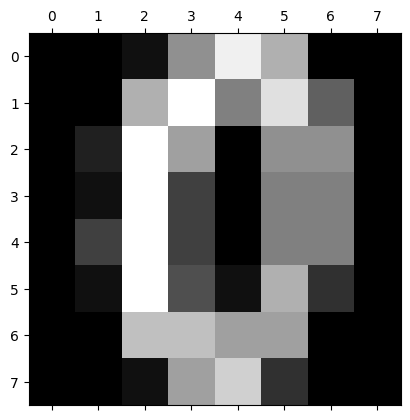

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

plt.matshow(digits.images[10], cmap='gray')

In [6]:
# Scale the feature value range to [0, 1]
X = digits.data / 16.
X = X * 2 - 1
# Target variable: One-hot-encoding: map each number of the interval [0,9] to a vector with 
# 9 zeros and a one, such that, e.g.,  2 is mapped to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Y = digits.target
# mask = np.isin(Y, 0)
# X = X[mask]

print("shape of X_train:", X.shape)
print("shape of Y_train:", Y.shape)
X.shape

shape of X_train: (1797, 64)
shape of Y_train: (1797,)


(1797, 64)

In [7]:
def running_mean(x, N):
    # code from https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

  0%|          | 0/2000 [00:00<?, ?it/s]

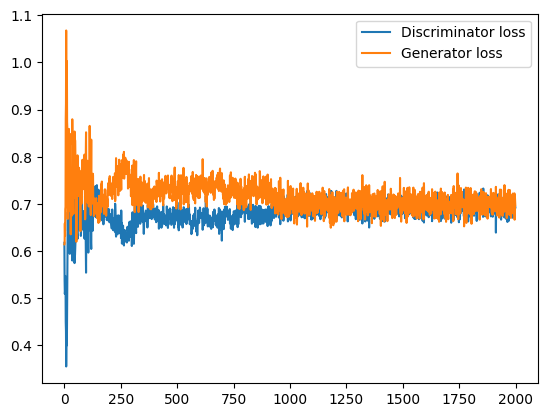

In [8]:
z_dim = 8

nn = Gan(BCE, dBCE_dy)

nn.add_layer(FullyConnectedLayer(X.shape[-1], 32), 'disc')
nn.add_layer(LeakyReLULayer(0.02), 'disc')
nn.add_layer(FullyConnectedLayer(32, 1), 'disc')
nn.add_layer(SigmoidLayer(), 'disc')

nn.add_layer(FullyConnectedLayer(z_dim, 32), 'gen')
nn.add_layer(ReLULayer(), 'gen')
nn.add_layer(FullyConnectedLayer(32, 48), 'gen')
nn.add_layer(ReLULayer(), 'gen')
nn.add_layer(FullyConnectedLayer(48, X.shape[-1]), 'gen')
nn.add_layer(TanhLayer(), 'gen')

train_gan = nn.train(X, z_dim, epochs=2000, learning_rate=1e-4, decay=1e-5, batch=64)
plt.plot(train_gan[:, 0], label='Discriminator loss')
plt.plot(train_gan[:, 1], label='Generator loss')
plt.legend()

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'mean loss'), (0.5, 1.0)]

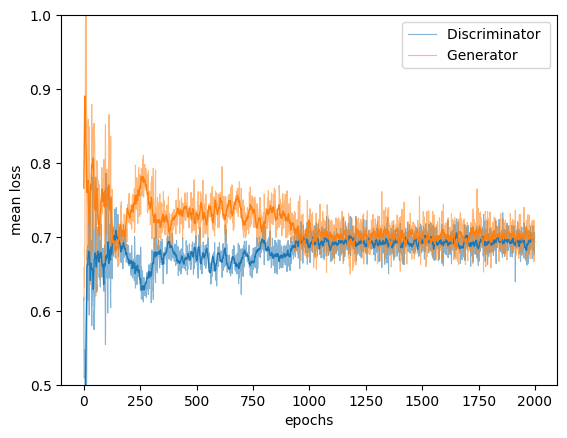

In [9]:
fig, ax = plt.subplots(ncols=1)
ax.plot(train_gan[:, 0], label='Discriminator ', c='C0', lw=0.8, alpha=0.55)
ax.plot(train_gan[:, 1], label='Generator ', c='C1', lw=0.8, alpha=0.55)
ax.plot(running_mean(train_gan[:, 0], 10),lw=1, c='C0')
ax.plot(running_mean(train_gan[:, 1], 10), lw=1, c='C1')

ax.legend()
ax.set(xlabel='epochs', ylabel='mean loss', ylim=(0.5, 1))


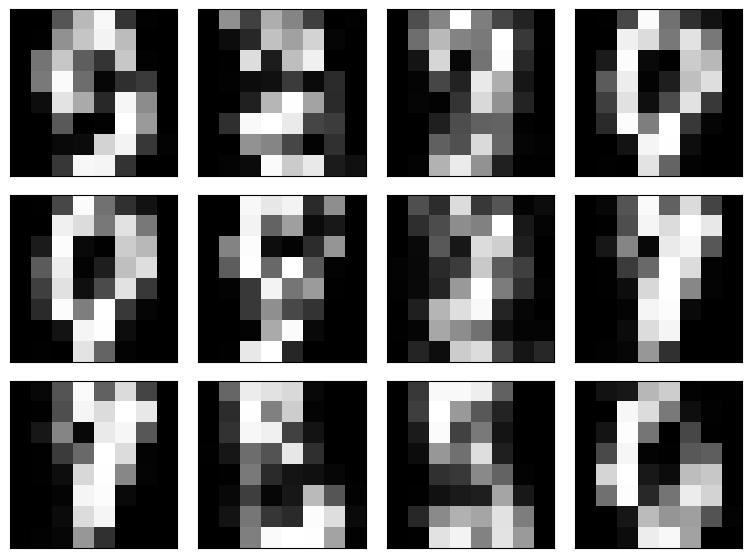

In [12]:
generated = nn.generate(12, z_dim)
generated = generated.reshape(-1, 8, 8)

fig, axs = plt.subplots(3, 4, figsize=(9.5, 7), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.11, 'wspace': 0.1})
for i in range(3):
    for j in range(4):
        axs[i, j].imshow(generated[i*3+j, ...], cmap='gray')
        axs[i, j].set(xticks=[], xticklabels=[], yticks=[], yticklabels=[])

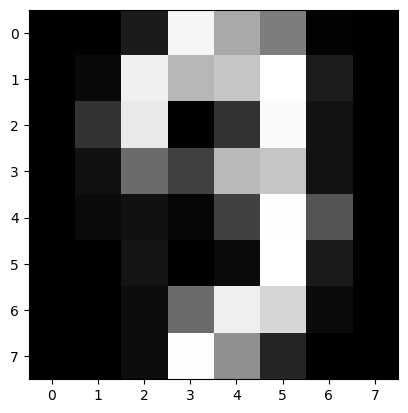

In [11]:
n_images = 4
generated_imgs = nn.generate(n_images, z_dim)
generated_imgs = generated_imgs.reshape(-1, 8, 8)
plt.imshow(generated_imgs[1], cmap='gray')